# Lecture 2: Supervised Learning

In this lab, you will learn to decode hand position from neural activity in the primate primary motor cortex (M1) using GLMs and random fores

In [1]:
import numpy as np
import scipy.io
import sklearn

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

#for plots
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)

colors=['#F5A21E', '#02A68E', '#EF3E34', '#134B64', '#FF07CD','b']

# Data
Below we load a dataset available on CRCNS: a [Macaque M1](http://crcns.org/data-sets/movements/dream/downloading-dream) (from [Stevenston et al. 2011](http://jn.physiology.org/content/106/2/764.short)).

The data has been organized in Matlab into neat arrays for easy loading here.

We will soon want a single numpy array representing the external covariates, and a single numpy vector representing the neural response. The data array X will be of dimensions (n, p), where n is the number of time bins and p is the number of covariates, and the response y will be of dimensions (n, ).

#### Load data

In [2]:
m1 = scipy.io.loadmat('m1_stevenson_2011.mat')
m1['time'] = m1['time'].squeeze()
m1['sampling_rate'] = 1/np.diff(m1['time']).mean()

### Plot raw M1 data

This gives some intuitive feeling for the type of data we're working with.

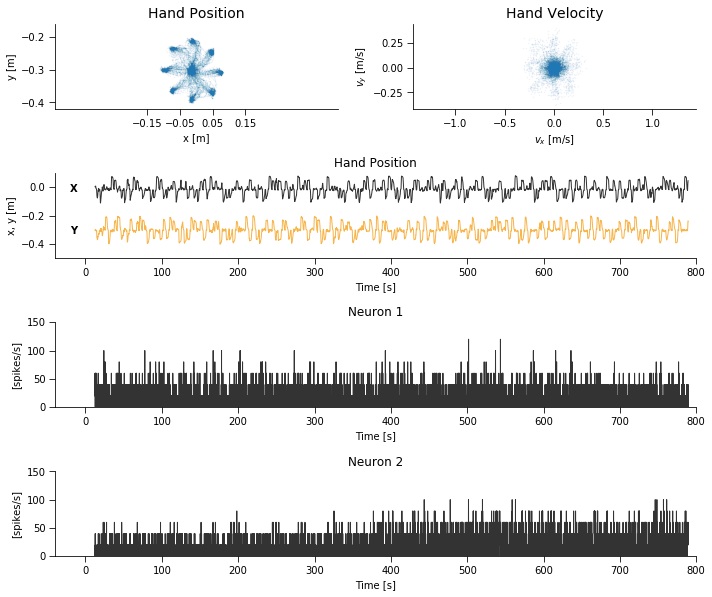

In [3]:
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'medium'

# Position scatter
ts = 14
gs0 = gridspec.GridSpec(5, 2)
plt.subplot(gs0[0,0])
simpleaxis(plt.gca())
plt.scatter(m1['handPos'][0,:], m1['handPos'][1,:], s=.1, alpha=.1)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.title('Hand Position',fontsize=ts)
plt.ylim([-0.42,-0.16])
plt.xlim([-0.15,0.15])
plt.xticks(np.arange(-0.15,0.2, .1))

# Velocity scatter
plt.subplot(gs0[0,1])
simpleaxis(plt.gca())
plt.scatter(m1['handVel'][0,:], m1['handVel'][1,:], s=.1, alpha=.1)

plt.xlabel('$v_x$ [m/s]')
plt.ylabel('$v_y$ [m/s]')
plt.axis('equal')
plt.title('Hand Velocity',fontsize=ts)

# Position trace
plt.subplot(gs0[1,:])
a=plt.gca()
simpleaxis(a)
a.text(-20,-.03,'X',weight='bold')
a.text(-20,-.33,'Y',weight='bold')
alpha = 0.8
lw = 1
plt.plot(m1['time'], m1['handPos'][0,:], 'k-', alpha=alpha, lw=lw)
plt.plot(m1['time'], m1['handPos'][1,:], '-', color=colors[0], alpha=alpha, lw=lw)
a.axis([-40,800,-0.5,0.1])

plt.xlabel('Time [s]')
plt.ylabel('x, y [m]')
plt.title('Hand Position')


# Neuron 1 firing rate
plt.subplot(gs0[2,:])
a=plt.gca()
simpleaxis(a)
alpha = 0.8
lw = 1
plt.plot(m1['time'], m1['sampling_rate']*m1['spikes'][0,:], 'k-', alpha=alpha, lw=lw)
a.axis([-40,800,0.0,150])

plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.title('Neuron 1')

# Neuron 1 firing rate
plt.subplot(gs0[3,:])
a=plt.gca()
simpleaxis(a)
alpha = 0.8
lw = 1
plt.plot(m1['time'], m1['sampling_rate']*m1['spikes'][1,:], 'k-', alpha=alpha, lw=lw)
a.axis([-40,800,0.0,150])

plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.title('Neuron 2')


plt.tight_layout()
plt.show()

## Exercise 1: Decode hand position from neural activity using a linear decoder
#### Ridge regression (The answer sheet)
#### Define Errors
* MSE (mean squared error)
* MAE (mean absolute error)
* $R^2$ (Coefficient of determination; https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAPE (mean absolute percentage error)

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import medfilt

def plot_positions(t, Y_test, Y_predict):
    """Plots true and predicted hand positions over time"""
    plt.figure(figsize=(15,10))
    a=plt.gca()
    simpleaxis(a)
    a.text(np.min(t)-20,-.03,'X',weight='bold')
    a.text(np.min(t)-20,-.33,'Y',weight='bold')
    alpha = 0.9
    lw = 1
    plt.plot(t_test, medfilt(Y_predict.T[0,:], 5), 'c-', t_test, Y_test.T[0,:], 'm-', alpha=alpha, lw=lw)
    plt.plot(t_test, medfilt(Y_predict.T[1,:], 5), 'c-', t_test, Y_test.T[1,:], 'm-', alpha=alpha, lw=lw)
    plt.legend(['pred', 'true'])
    plt.xlabel('Time [s]')
    plt.ylabel('x, y [m]')
    plt.title('Hand Position')
    plt.show()
    
def mean_absolute_percentage_error(Y_test, Y_predict):
    return float(np.mean(np.abs((Y_test - Y_predict)/Y_predict)))

def score_positions(Y_test, Y_predict):
    """Scores given hand positions using standard metrics"""
    return (mean_squared_error(Y_test, Y_predict),
            mean_absolute_error(Y_test, Y_predict),
            r2_score(Y_test, Y_predict),
            mean_absolute_percentage_error(Y_test, Y_predict))

def print_scores(score_, labels):
    for score, label in zip(score_, labels):
        print(f'{label}:{score}')

#### Split for time-series data using `TimeSeriesSplit`

In [5]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(range(20)):
    print((train_index, test_index))

(array([0, 1, 2, 3, 4]), array([5, 6, 7]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 8,  9, 10]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([11, 12, 13]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([14, 15, 16]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), array([17, 18, 19]))


In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model

# load data (X is neural activity, Y is hand position response)
Y = m1['handPos'].T[:,0:2]
X = m1['spikes'].T
t = m1['time']

m_ = linear_model.RidgeCV()

# Generate 5 different splits of your data into train and test data sets for cross validation
tscv = TimeSeriesSplit(n_splits=5)
score_ = []
label = ['MSE', 'MAE', 'COD', 'MAPE']
# iterate through time splits and train/predict
for train_index, test_index in tscv.split(t):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    t_train, t_test = t[train_index], t[test_index]
    
    m_.fit(X_train, Y_train)
    Y_predict = m_.predict(X_test)
    _ = score_positions(Y_test, Y_predict)
    score_.append(_)
    # print_scores(_, label)
    # plot_positions(t_test, Y_test, Y_predict)
    
label_ = ['avg MSE', 'avg AE', 'avg COD', 'avg MAPE']
print_scores(np.array(score_).mean(axis=0), label_)

avg MSE:0.0010101438567677572
avg AE:0.025288677753359433
avg COD:0.4926227819698889
avg MAPE:2.4040062297241453


## Exercise 2: Find the 10 best neurons for decoding hand position
#### linear regression model with L1 regularization (lasso)
#### The answer sheet -- Multi-task lasso regression
#### Try -- lasso regression for each dimension

In [7]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
import time

# load data (X is neural activity, Y is hand position response)
Y = m1['handPos'].T[:,0:2]
X = m1['spikes'].T
t = m1['time']

# Generate 5 different splits of your data into train and test data sets for cross validation
tscv = TimeSeriesSplit(n_splits=5)

m_ = linear_model.MultiTaskLassoCV() # This is wired to use CV over CV
score_ = []
label = ['MSE', 'MAE', 'COD', 'MAPE']
avg_neuron_weights = []
# iterate through time splits and train/predict
for train_index, test_index in tscv.split(t):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    t_train, t_test = t[train_index], t[test_index]    
    """
    Fit your linear regression model with L1 regularization (lasso) here, 
    extract relevant metrics and plot test performance.
    """
    t0 = time.time()
    m_.fit(X_train, Y_train)
    t1 = time.time()
    print( 'Running time: {} '.format( t1 - t0 ))
    Y_predict = m_.predict(X_test)
    avg_neuron_weights.append(np.mean(m_.coef_, axis=0))
    _ = score_positions(Y_test, Y_predict)
    score_.append(_)
    # print_scores(_, label)
    # plot_positions(t_test, Y_test, Y_predict)

label_ = ['avg MSE', 'avg AE', 'avg COD', 'avg MAPE']
print_scores(np.array(score_).mean(axis=0), label_)

avg_neuron_weights = np.mean(avg_neuron_weights, axis=0)
ind = np.argpartition(avg_neuron_weights, -10)[-10:]
print("10 best neurons: {0}".format(ind))

Running time: 77.34440970420837 
Running time: 147.0495090484619 
Running time: 205.11525511741638 
Running time: 206.6320276260376 
Running time: 219.89097142219543 
avg MSE:0.0010065371575277925
avg AE:0.025292424976447958
avg COD:0.4941228576483434
avg MAPE:2.5854414714223166
10 best neurons: [  2 141  32 111  50  59  48  16  98 154]


## Exercise 3: Build the best possible nonlinear decoder
### Hints:

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import ensemble

# load data (X is neural activity, Y is hand position response)
Y = m1['handPos'].T[:,0:2]
X = m1['spikes'].T
t = m1['time']

# Generate 5 different splits of your data into train and test data sets
tscv = TimeSeriesSplit(n_splits=5)
scores=[]

# iterate through time splits and train/predict
for train_index, test_index in tscv.split(t):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    t_train, t_test = t[train_index], t[test_index]
    
    """
    Experiment and find/implement the best performing non-linear model here, 
    start with a Random Forest Classifier and compare your results to the linear models, iterate.
    Extract relevant metrics and plot test performance.
    """

    clf1 = ensemble.GradientBoostingRegressor(loss='huber',n_estimators=100)
    clf1.fit(X_train, Y_train[:,0])
    clf2 = ensemble.GradientBoostingRegressor(loss='huber',n_estimators=100)
    clf2.fit(X_train, Y_train[:,1])
    Y1_predict = clf1.predict(X_test)
    Y2_predict = clf2.predict(X_test)
    Y_predict = np.stack([Y1_predict, Y2_predict], axis=-1)
    
    (mse, mae, cod, mape) = score_positions(Y_test, Y_predict)
    scores.append([mse, mae, cod, mape])
#     print("MSE: {0}".format(mse))
#     print("MAE: {0}".format(mae))
#     print("COD: {0}".format(cod))
#     print("MAPE: {0}".format(mape))
#     plot_positions(t_test, Y_test, Y_predict)

scores = np.array(scores)
avg_scores = np.mean(scores, axis=0)

print("avg MSE: {0}".format(avg_scores[0]))
print("avg MAE: {0}".format(avg_scores[1]))
print("avg COD: {0}".format(avg_scores[2]))
print("avg MAPE: {0}".format(avg_scores[3]))

avg MSE: 0.0009867692274481683
avg MAE: 0.024812247601302184
avg COD: 0.5026438834156697
avg MAPE: 3.420709600053628


## Exercise 4: Build an encoding model for neuron 0 to predict neural activity from hand position and velocity using a linear-nonlinear-Poisson GLM
### GLM runs using `statsmodels`

In [9]:
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [10]:
# function to convert cartesian coordinates to radial coordinates
def convert_2_angular_coord(Y):
    radius = np.sqrt(Y[:,0]**2+Y[:,1]**2).reshape([-1,1])
    radius = radius
    angle = np.angle(Y[:,0]+Y[:,1]*1j, deg=False).reshape([-1,1])
    angle = np.cos(angle)
    return radius, angle

# create meshgrid to plot tuninng curves
def create_dummy_xy_coordinates(Y_centered):
    ''' return augmented dummy Y - Tx [1, x_coord, y_coord]'''
    ymax = Y_centered.max(axis = 0).max()
    ymin = Y_centered.min(axis = 0).min()
    x_coord = np.arange(ymin, ymax, 0.01)
    y_coord = np.arange(ymin, ymax, 0.01)
    xx_cart_coord, yy_cart_coord = np.meshgrid(x_coord, y_coord)
    return xx_cart_coord, yy_cart_coord

def augment_data(Y):
    return np.hstack([np.ones([Y.shape[0],1]),Y]) 

In [11]:
# center data
Y_centered = Y-Y.mean(axis = 0)
# don't forget to add a bias term
Y_cart = augment_data(Y_centered)

# convert to radial coordinate
radius, angle = convert_2_angular_coord(Y)
# don't forget to add a bias term
Y_rad = augment_data(np.hstack([radius, angle]))

# combine both?
Y_comb = np.hstack([Y_cart, radius, angle])


In [12]:
# select your favourite neurons
best_neurons = [0, 2, 141, 32, 111, 50, 59, 48, 16, 98, 154]

In [13]:
# generate dummy hand coordinates in both cartesian and radial coordinates
# for cartesian coordinates
xx_cart_coord, yy_cart_coord  = create_dummy_xy_coordinates(Y_centered)
Y_cart_dummy = augment_data(np.vstack([ xx_cart_coord.flatten(), yy_cart_coord.flatten()]).T )   

# repeat for radial coordinates
radius_dummy, angle_dummy = convert_2_angular_coord(Y_cart_dummy[:,1:3])
Y_rad_dummy = augment_data(np.hstack([radius_dummy, angle_dummy]))

# repeat for both (or add your favourite features)
Y_comb_dummy = np.hstack([Y_cart_dummy, radius_dummy, angle_dummy])

In [14]:
def run_model(neuron_num, X, Y_cart, Y_cart_dummy, xx_cart):
    ## split data
    ## create a model
    ## fit model
    ## predict firing rate on dummy grid
    
    X_train, X_test, y_train, y_test = train_test_split(X[:,neuron_num:neuron_num+1], Y_cart, test_size=0.33, random_state=0) 
    poisson_model = sm.GLM(X_train, y_train,\
                      family=sm.families.Poisson()) 
    results = poisson_model.fit() 
    rate_pred = results.predict(Y_cart_dummy)
    rate_pred = rate_pred.reshape([xx_cart.shape[0],-1])
    data = [X_train, X_test, y_train, y_test] 
    
    return poisson_model, results, rate_pred, data

In [15]:
poisson_model_cart, results_cart, rate_pred_cart, data_cart = \
run_model(best_neurons[0], X, Y_cart, Y_cart_dummy, xx_cart_coord)

poisson_model_radial, results_radial, rate_pred_radial, data_radial = \
run_model(best_neurons[0], X, Y_rad, Y_rad_dummy, xx_cart_coord)

poisson_model_comb, results_comb, rate_pred_comb, data_comb = \
run_model(best_neurons[0], X, Y_comb, Y_comb_dummy, xx_cart_coord)

In [16]:
print(results_cart.summary())
print(results_radial.summary())
print(results_comb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10409
Model:                            GLM   Df Residuals:                    10406
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10311.
Date:                Thu, 20 Sep 2018   Deviance:                       11025.
Time:                        00:27:18   Pearson chi2:                 1.09e+04
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5835      0.013    -44.424      0.000      -0.609      -0.558
x1            -0.7235      0.307     -2.360      0.0

In [17]:
def plot_predictions(rate_pred_cart,rate_pred_radial,rate_pred_comb, xx_cart_coord, title):
    fig = plt.figure(figsize = (21,10))
    extent = [xx_cart_coord[0,0],xx_cart_coord[-1,-1], xx_cart_coord[0,0],xx_cart_coord[-1,-1]] 
    fig.add_subplot(1,3,1)
    plt.imshow(rate_pred_cart, extent = extent)
    plt.title('predicted firing rate with \ncartesian basis', fontsize = 23)
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')

    fig.add_subplot(1,3,2)
    plt.imshow(rate_pred_radial, extent = extent)
    plt.title('predicted firing rate with \nradial basis', fontsize = 23)
    plt.yticks([])
    plt.xlabel('x coordinate')

    fig.add_subplot(1,3,3)
    plt.imshow(rate_pred_comb, extent = extent)
    plt.title('predicted firing rate with \nboth feature vector', fontsize = 23)

    plt.yticks([])
    plt.xlabel('x coordinate')
    plt.suptitle(title)
    # plt.ylabel('y coordinate')
    plt.tight_layout()

In [18]:
for i, ind in enumerate(best_neurons):
    poisson_model_cart, results_cart, rate_pred_cart, data_cart = \
    run_model(best_neurons[i], X, Y_cart, Y_cart_dummy, xx_cart_coord)


    poisson_model_radial, results_radial, rate_pred_radial, data_radial = \
    run_model(best_neurons[i], X, Y_rad, Y_rad_dummy, xx_cart_coord)

    poisson_model_comb, results_comb, rate_pred_comb, data_comb = \
    run_model(best_neurons[i], X, Y_comb, Y_comb_dummy, xx_cart_coord)
#     title = 'neuron ' + str(ind)
#     plot_predictions(rate_pred_cart,rate_pred_radial,rate_pred_comb, xx_cart_coord, title)

In [19]:
#sample from the inferred distribution (this is for the last neuron)
x_hat = results_cart.mu
samples = np.random.poisson(x_hat)

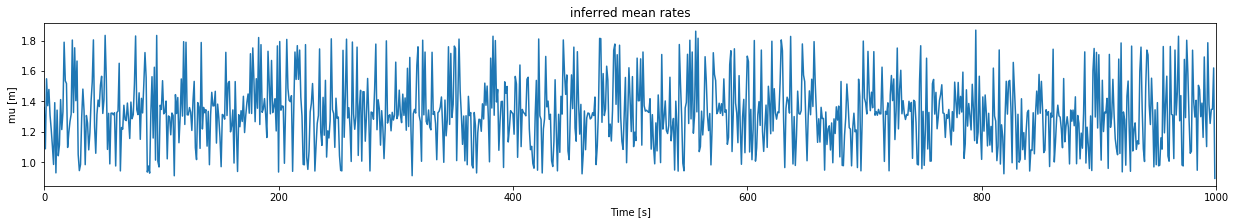

In [20]:
fig = plt.figure(figsize = (21, 3))
title = 'inferred mean rates'
plt.title(title)
minmax = (0, 1000)
plt.plot(x_hat[minmax[0]:minmax[1]])
plt.xlabel('Time [s]')
plt.ylabel('mu [m]')
plt.xlim([minmax[0],minmax[1]])
plt.show()

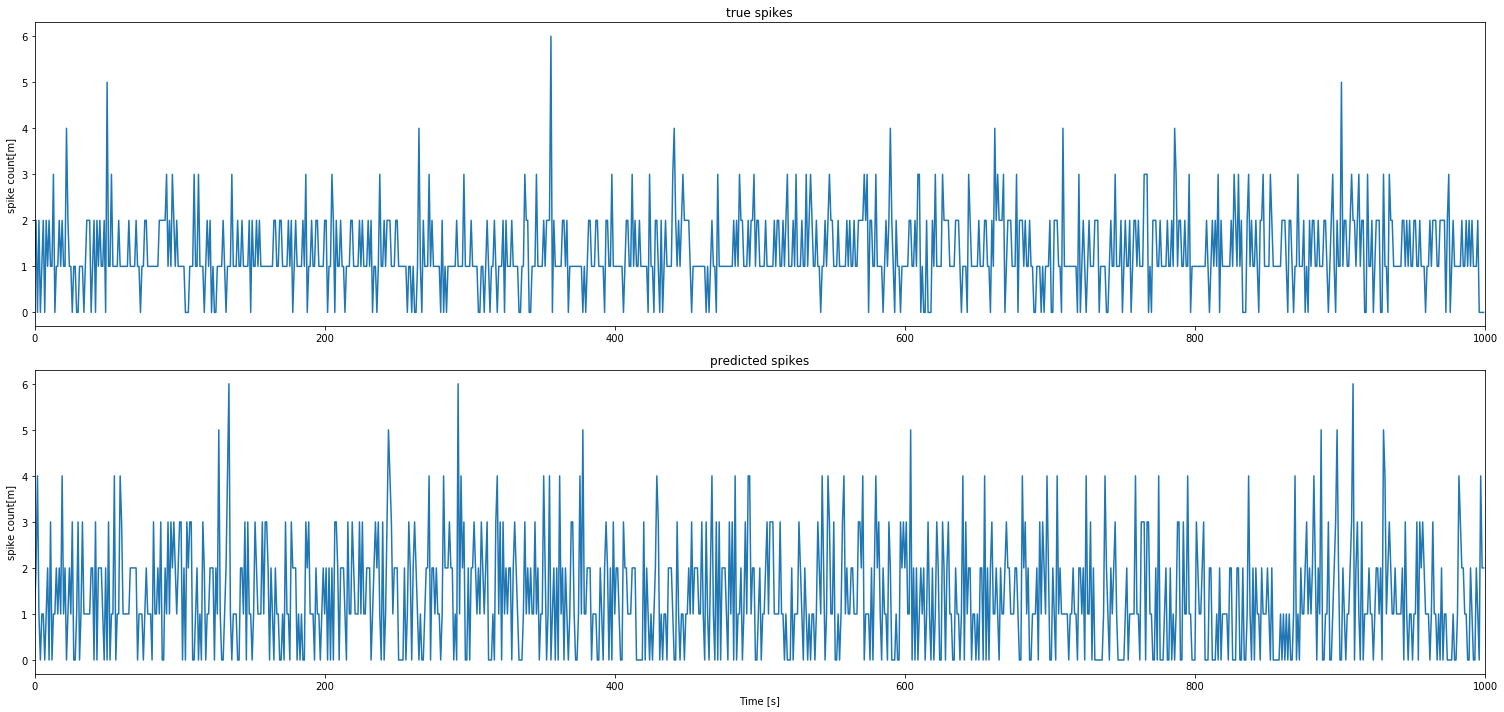

In [21]:
# sample from the inferred distribution 
fig = plt.figure(figsize = (21, 10))
title = 'inferred mean rates'
minmax = (0, 1000)
X_test = data_cart[1]
fig.add_subplot(2,1,1)
plt.plot(X_test[minmax[0]:minmax[1]])
# plt.xlabel('Time [s]')
plt.title('true spikes')
plt.ylabel('spike count[m]')
plt.xlim([minmax[0],minmax[1]])
fig.add_subplot(2,1,2)
plt.plot(samples[minmax[0]:minmax[1]])
plt.xlabel('Time [s]')
plt.title('predicted spikes')
plt.ylabel('spike count[m]')
plt.xlim([minmax[0],minmax[1]])
plt.tight_layout()

#### Default link function of Poisson is `log` where $E(Y) = \exp(\beta X)$
#### Fit with other link function of Poisson

In [22]:
sm.families.family.Poisson.links

[statsmodels.genmod.families.links.log,
 statsmodels.genmod.families.links.identity,
 statsmodels.genmod.families.links.sqrt]

/groups/ahrens/home/weiz/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:302: DomainWarning: The sqrt link function does not respect the domain of the Poisson family.
  DomainWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10409
Model:                            GLM   Df Residuals:                    10406
Model Family:                 Poisson   Df Model:                            2
Link Function:                   sqrt   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13394.
Date:                Thu, 20 Sep 2018   Deviance:                       5769.3
Time:                        00:27:19   Pearson chi2:                 5.55e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1464      0.005    233.922      0.000       1.137       1.156
x1            -1.0749      0.115     -9.365      0.0

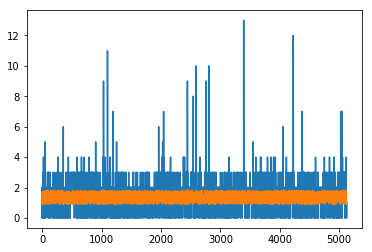

In [23]:
# center data
Y_centered = Y-Y.mean(axis = 0)
# don't forget to add a bias term
Y_cart = augment_data(Y_centered)
X_train, X_test, y_train, y_test = train_test_split(X[:,154], Y_cart, test_size=0.33, random_state=0) 
poisson_model = sm.GLM(X_train, y_train,family=sm.families.Poisson(sm.genmod.families.links.sqrt)) 
results = poisson_model.fit() 
rate_pred = results.predict(Y_cart_dummy)
rate_pred = rate_pred.reshape([xx_cart_coord.shape[0],-1])
data = [X_train, X_test, y_train, y_test]
plt.plot(X_test)
plt.plot(results.predict(y_test))
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10409
Model:                            GLM   Df Residuals:                    10406
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13392.
Date:                Thu, 20 Sep 2018   Deviance:                       5766.2
Time:                        00:27:20   Pearson chi2:                 5.55e+03
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2658      0.009     30.757      0.000       0.249       0.283
x1            -1.9231      0.201     -9.574      0.0

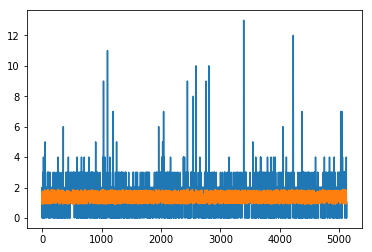

In [24]:
# center data
Y_centered = Y-Y.mean(axis = 0)
# don't forget to add a bias term
Y_cart = augment_data(Y_centered)
X_train, X_test, y_train, y_test = train_test_split(X[:,154], Y_cart, test_size=0.33, random_state=0) 
poisson_model = sm.GLM(X_train, y_train,family=sm.families.Poisson(sm.genmod.families.links.log)) 
results = poisson_model.fit() 
rate_pred = results.predict(Y_cart_dummy)
rate_pred = rate_pred.reshape([xx_cart_coord.shape[0],-1])
data = [X_train, X_test, y_train, y_test]
plt.plot(X_test)
plt.plot(results.predict(y_test))
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10409
Model:                            GLM   Df Residuals:                    10406
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13397.
Date:                Thu, 20 Sep 2018   Deviance:                       5775.3
Time:                        00:27:20   Pearson chi2:                 5.55e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3239      0.011    117.376      0.000       1.302       1.346
x1            -2.3586      0.259     -9.104      0.0

/groups/ahrens/home/weiz/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:302: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


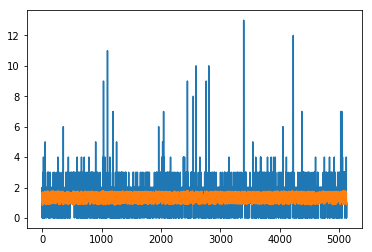

In [25]:
# center data
Y_centered = Y-Y.mean(axis = 0)
# don't forget to add a bias term
Y_cart = augment_data(Y_centered)
X_train, X_test, y_train, y_test = train_test_split(X[:,154], Y_cart, test_size=0.33, random_state=0) 
poisson_model = sm.GLM(X_train, y_train,family=sm.families.Poisson(sm.genmod.families.links.identity)) 
results = poisson_model.fit() 
rate_pred = results.predict(Y_cart_dummy)
rate_pred = rate_pred.reshape([xx_cart_coord.shape[0],-1])
data = [X_train, X_test, y_train, y_test]
plt.plot(X_test)
plt.plot(results.predict(y_test))
print(results.summary())